# Implementación de aloritmos de selección de variales para clustering

In [7]:
import pandas as pd
import numpy as np
import glob, sys, os
import pytraj as pyt
sys.path.append(r'..')

In [46]:
prot_name = 'cdk2'
# Este es el DF que no tiene aun afgregados los valores AUC de las conformaciones
path_string = '../data/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS_AUC_docking.json'.split('/')
path_to_json_file = glob.glob((os.path.join(*path_string)))[0]
                      
df_prot = pd.read_json(path_to_json_file)
df_prot.head()

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,Labels_conf,AUC_vrd_16x,AUC_vina_16x,AUC_ad4_LC,AUC_ad4_LE
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.00,298,92.953020,2,"[8, 13]","[[36, 43], [149, 161]]",1,['STU'],STU,440.0,inact_b,0.730317,0.575339,0.634163,0.572172
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.00,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a,0.677828,0.546154,0.571946,0.483032
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.10,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a,0.764706,0.580543,0.670814,0.607919
1buh,crystal structure of the human cdk2 kinase com...,1998-09-09,2,A,2.60,298,96.308725,2,"[7, 4]","[[40, 46], [295, 298]]",0,[],,,inact_a,0.708145,0.535294,0.613348,0.544344
1ckp,human cyclin dependent kinase 2 complexed with...,1999-01-13,1,A,2.05,298,93.624161,2,"[8, 11]","[[36, 43], [153, 163]]",2,"['EDO', 'PVB']",PVB,214.0,inact_a,0.766968,0.571493,0.764932,0.715385


In [8]:
# Carga de la trayectoria de estructuras cristalograficas
file_pdb_traj_pisani = (os.path.join('..', '..', 'ARCHIVOS', 'CRISTALES', 'TRAJ_CRISTALS_PDB',
                        F'PDB_402_cdk2_PISANI_ALL.pdb'))
traj_crystals = pyt.load(file_pdb_traj_pisani)

print(F'Número de frames: {traj_crystals.n_frames}.\nNúmero de átomos: {traj_crystals.n_atoms}.')

Número de frames: 402.
Número de átomos: 4848.


In [ ]:
# PCA

In [35]:
from copy import copy
from sklearn.decomposition import PCA
pca_obj = make_pipeline(StandardScaler(),
                    PCA(n_components= 2))

In [36]:
def get_new_dimentions(dmr_obj, traj, frames = None, atom_mask = "@CA", nca = False, y = None):
    ''' Retorna un objeto pca dada una trayectoria de pytraj y una mascara de selección'''
    if frames is None:
        frames = range(0, traj.n_frames)
    traj_subset = traj_crystals[frames, atom_mask]
    xyz_2d_array = traj_subset.xyz.reshape(traj_subset.n_frames, traj_subset.n_atoms * 3)
    # Crea una copia del estimador para evitar reentrenar el mismo objeto
    dmr_obj_copy = copy(dmr_obj)
    if nca:
        reduced = dmr_obj_copy.fit_transform( X = xyz_2d_array, y = y)
    else:
        reduced = dmr_obj_copy.fit_transform( xyz_2d_array )
    return reduced

In [38]:
from modules.plotting_functions import plot_points, plot_anotation_labels
import matplotlib.pyplot as plt

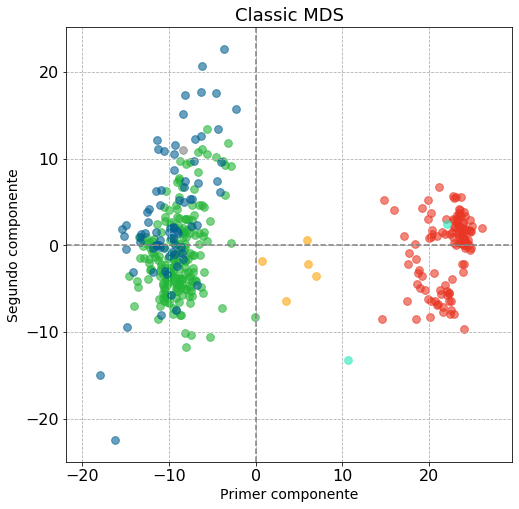

In [56]:
pyt.align(traj_crystals, "@CA")
# PCA
pca_pyt_all = get_new_dimentions(pca_obj, traj_crystals, atom_mask = pisani_mask)

plt.figure(figsize = (8,8))
plot_points(mds = pca_pyt_all.T, labels = df_prot.Labels_conf)

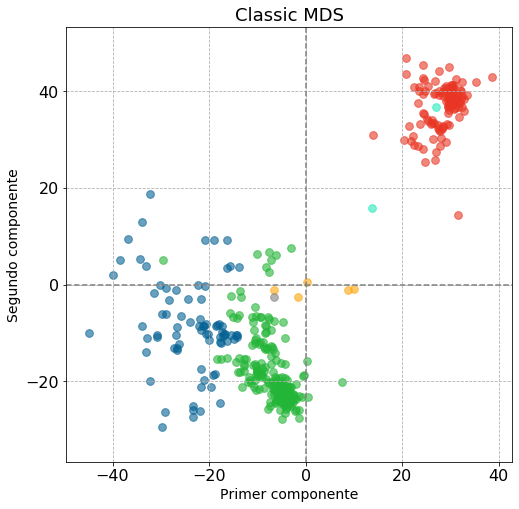

In [319]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NeighborhoodComponentsAnalysis
nca = make_pipeline(StandardScaler(),
                    NeighborhoodComponentsAnalysis(n_components = 2, init='identity'))

pca_pyt_all = get_new_dimentions(nca, traj_crystals, 
                                 atom_mask = "@CA", nca = True, y = df_prot.Labels_conf)
plt.figure(figsize = (8,8))
plot_points(mds = pca_pyt_all.T, labels = df_prot.Labels_conf)

In [328]:
nca['neighborhoodcomponentsanalysis'].components_

array([[ 0.94908924, -0.07569746, -0.04022194, ..., -0.00247199,
         0.02519549,  0.02117861],
       [ 0.12844587,  0.93065013, -0.03162072, ...,  0.02214466,
        -0.00259687, -0.1158108 ]])

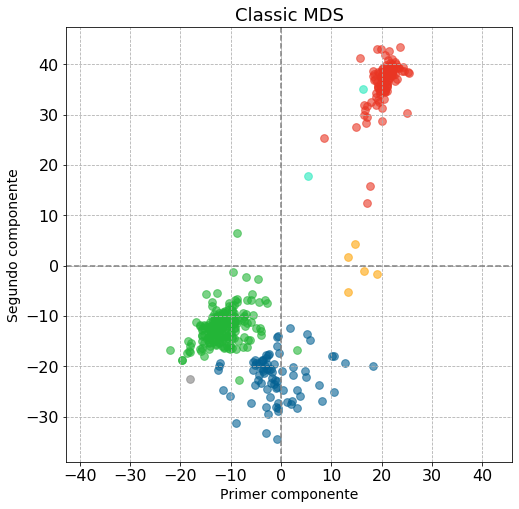

In [52]:
from modules.subsecuencias_cdk2 import *
pisiani_residues = get_pisani_residues(sep=",") # subsecuencia de la estructura secuendaria
pocket_residues = get_pocket_residues(sep=",")
# Máscara indicando los CA de los residuos de Pisani
pisani_mask = F"(:{pisiani_residues})&(@CA)"

pca_pyt_all = get_new_dimentions(nca, traj_crystals, 
                                 atom_mask = pisani_mask, nca = True, y = df_prot.Labels_conf)
plt.figure(figsize = (8,8))
plot_points(mds = pca_pyt_all.T, labels = df_prot.Labels_conf)

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


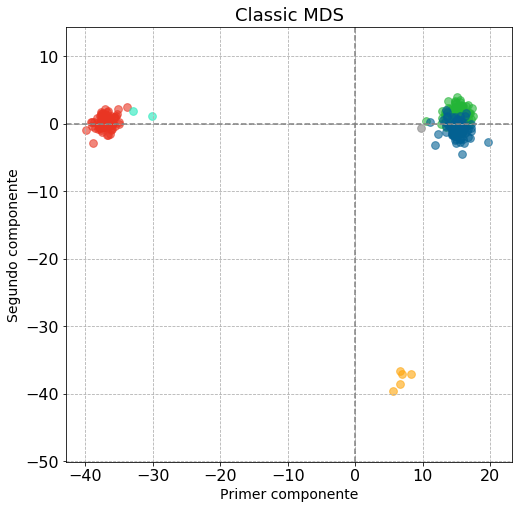

In [366]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = make_pipeline(#StandardScaler(),
                   LinearDiscriminantAnalysis(n_components = 2))

pca_pyt_all = get_new_dimentions(lda, traj_crystals, 
                                 atom_mask = '!@H', nca = True, y = df_prot.Labels_conf)
plt.figure(figsize = (8,8))
plot_points(mds = pca_pyt_all.T, labels = df_prot.Labels_conf)



In [367]:
# Obtenemos la varianza explicada de cada una de las dimensiones
lda['lineardiscriminantanalysis'].explained_variance_ratio_

array([0.94574516, 0.0315376 ])

In [368]:
# Ahora obtenemos el peso de cada variable en cada una de las n dimensiones
# En este caso, por default, LDA calcula k - 1 dimensiones, donde k es el número de
# clases que recibe en el párametro y

# Valores en la dimensión 1
atoms_scalings_d1 = lda['lineardiscriminantanalysis'].scalings_.T[0]
print(F'El número de variables evaluadas es: {len(atoms_scalings_d1)}')
# Recordar que el número de variables evaluadas es igual al número de átomos*3

El número de variables evaluadas es: 13710


In [369]:
# Ahora reestructuramos el arreglo de pesos de las variables en la dimesión 1 a un arreglo de nAtomos*3
# Para así, asignar los pesos de las tres coordenadas a su átomo respectivo
# tal que se a posible determinar qué átomo contribuye más a las dimensiones del LDA
n_atoms_ = len(atoms_scalings_d1)/3
atoms_scalings_d1_resahped = atoms_scalings_d1.reshape((int(n_atoms_), 3))

len(atoms_scalings_d1_resahped)

4570

In [370]:
# Ahora generamos un nuevo arreglo por átomos en el que a cada átomo se le sume el cuadrado
# de los desplazamientos de cada uno de sus valores en las tres coordenadas
atom_weights_ = np.sum(atoms_scalings_d1_resahped**2, axis=1)
atom_weights_

array([6.58250987e-06, 1.18005251e-05, 9.48422803e-06, ...,
       1.60221872e-06, 2.53467083e-06, 1.95717974e-06])

In [371]:
atom_weights_[atom_weights_ > 5]

array([], dtype=float64)

In [372]:
# Signación de colores
[range(0, 31)]

[range(0, 31)]

In [381]:
filtro = pd.qcut(pd.Series(atom_weights_), 10, labels=[i for i in range(1, 11)]) == 10
indices = filtro[filtro].index
indices_str = ','.join(map(str, list(indices)))
len(indices)

457

In [382]:
"@" + indices_str

'@754,817,830,831,833,834,852,854,855,856,858,904,912,913,914,924,925,928,934,940,942,957,958,959,960,961,995,1307,1308,1309,1310,1312,1323,1324,1325,1327,1357,1358,1524,1572,1573,1574,1575,1577,1588,1591,1605,1606,1607,1608,1609,1610,1612,1617,1626,1627,1636,1637,1639,1640,1642,1644,1645,1646,1647,1648,1649,1651,1656,1657,1658,1661,1664,1675,1676,1677,1679,1680,1683,1684,1686,1693,1696,1697,1698,1700,1701,1702,1703,1704,1706,1707,1709,1710,1727,1728,1729,1730,1733,1744,1745,1746,1747,1748,1749,1750,1756,1761,1762,1763,1764,1765,1767,1768,1770,1771,1785,1786,1787,1789,1795,1807,1817,1840,1904,1921,1922,1923,1924,1926,1927,1929,1961,1963,1965,1966,1971,1973,1974,1975,1989,1990,1991,1992,1994,1997,1999,2012,2022,2023,2054,2056,2058,2061,2071,2074,2089,2090,2091,2092,2093,2154,2162,2165,2166,2171,2173,2174,2175,2176,2177,2178,2179,2180,2181,2188,2201,2202,2203,2204,2207,2229,2231,2232,2239,2554,2557,2558,2559,2570,2571,2572,2573,2578,2579,2581,2582,2583,2588,2589,2591,2593,2596,2597,2598,

In [383]:
# Visualización con nglview
import nglview as nv
from nglview.color import ColormakerRegistry
import pytraj as pyt
import os
import seaborn as sns

path_to_structure = '../../ARCHIVOS/CRISTALES/PROT_CDK2_PREPARADAS/PREP_ALL_ENSAMBLE/1fin_ENS.pdb'.split('/')
ref_structure = pyt.load(os.path.join(*path_to_structure))

view = nv.show_pytraj(ref_structure)
cm.add_selection_scheme('cd',
                       [['red', "@" + indices_str]])
view.clear()
view.add_licorice(color='cd')
view

NGLWidget()

In [337]:
# # Visualización con nglview
# import nglview as nv
# from nglview.color import ColormakerRegistry
# import pytraj as pyt
# import os
# import seaborn as sns

# path_to_structure = '../../ARCHIVOS/CRISTALES/PROT_CDK2_PREPARADAS/PREP_ALL_ENSAMBLE/1fin_ENS.pdb'.split('/')
# ref_structure = pyt.load(os.path.join(*path_to_structure))

# view = nv.show_pytraj(ref_structure)
# cm.add_selection_scheme('cd',
#                        [['red', indices_str]])
# view.clear()
# view.add_cartoon(color='cd')
# view

NGLWidget()

In [312]:
mask_lda = F':{",".join(map(str, list(indices)))}&CA'
len(indices)

99

In [384]:
traj_crystals['@' + indices_str]

pytraj.Trajectory, 402 frames: 
Size: 0.004106 (GB)
<Topology: 457 atoms, 100 residues, 0 mols, non-PBC>
           

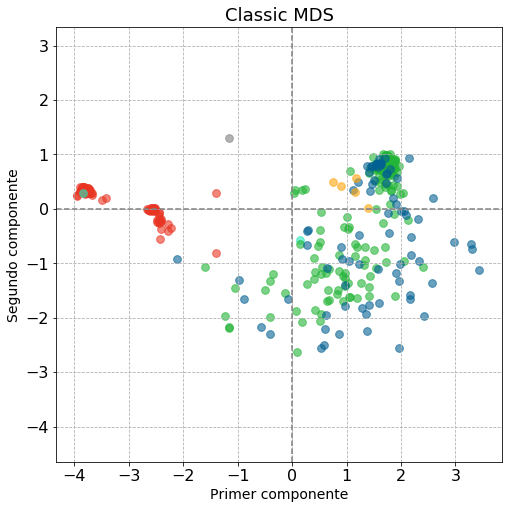

In [385]:
from modules.MDS import cMDS
# mask_lda = F':{",".join(map(str, list(indices)))}&(@CA)'
#mask_lda = F':{",".join(map(str, list(indices)))}&(@CA)'

pyt.align(traj_crystals, mask_lda)
rmsd_pairs = pyt.pairwise_rmsd( traj = traj_crystals, mask= '@' + indices_str, metric="rms")

mds_total = cMDS(rmsd_pairs)
plt.figure(figsize = (8,8))
plot_points(mds = mds_total[0], labels = df_prot.Labels_conf)


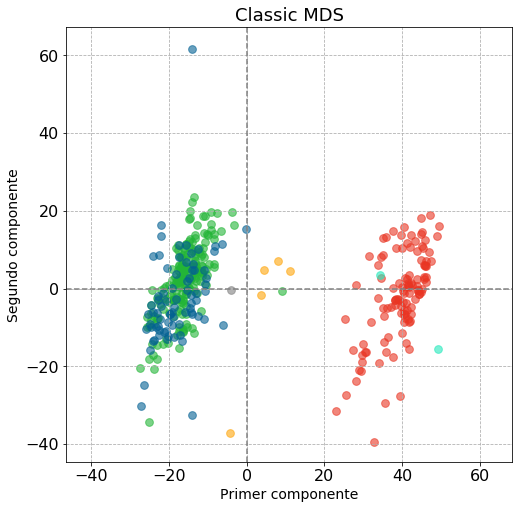

In [388]:
mask_lda = F':{",".join(map(str, list(indices)))}&(@CA)'

pyt.align(traj_crystals, pisani_mask)
# PCA
pca_pyt_all = get_new_dimentions(pca_obj, traj_crystals, atom_mask = '@' + indices_str)

plt.figure(figsize = (8,8))
plot_points(mds = pca_pyt_all.T, labels = df_prot.Labels_conf)

In [236]:
sns_color_palette = sns.cubehelix_palette(ref_structure['@CA'].n_atoms).as_hex()
string_residues = [str(i) for i in range(1, ref_structure['@CA'].n_atoms + 1)]

In [237]:
cm = ColormakerRegistry

sns_color_palette = sns.cubehelix_palette(ref_structure['@CA'].n_atoms).as_hex()


cm.add_selection_scheme('cd',
                       list(zip(sns_color_palette, string_residues)))
view.clear()
view.add_cartoon(color='cd')
view

NGLWidget(n_components=1)

array([[-0.03440031, -0.11210862,  0.24518883],
       [-0.36848372,  0.08028936, -0.45704925],
       [-0.16618577,  0.53664133, -0.1610182 ],
       ...,
       [ 0.05876702, -0.2018227 , -0.05816473],
       [ 0.22591243,  0.08264973, -0.30941062],
       [ 0.47149306,  0.22276454,  0.12532315]])

1aq1    3
1b38    3
1b39    4
1buh    3
1ckp    4
       ..
6q4g    2
6q4h    1
6q4i    2
6q4j    1
6q4k    2
Name: AUC_vrd_16x, Length: 402, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


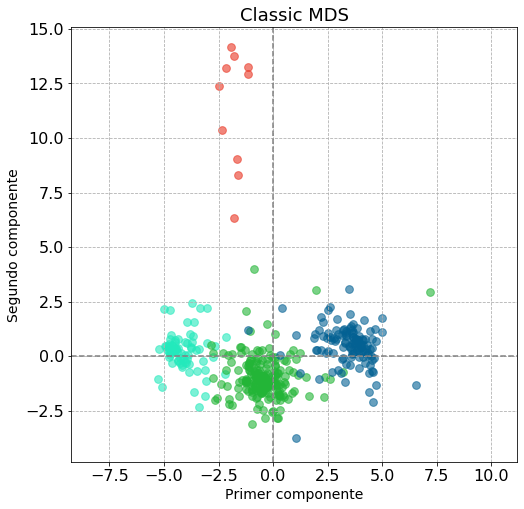

In [407]:
lda = make_pipeline(#StandardScaler(),
                   LinearDiscriminantAnalysis(n_components = 2))

labels_ =  pd.cut(df_prot.AUC_vrd_16x, 4, labels =[ 1, 2, 3, 4])

pca_pyt_all = get_new_dimentions(lda, traj_crystals, 
                                 atom_mask = '@CA', nca = True, y = labels_)
plt.figure(figsize = (8,8))
plot_points(mds = pca_pyt_all.T, labels = labels_)

In [408]:
lda['lineardiscriminantanalysis'].explained_variance_ratio_

array([0.49456051, 0.27185653])

In [409]:
# Valores en la dimensión 1
atoms_scalings_d1 = lda['lineardiscriminantanalysis'].scalings_.T[0]
print(F'El número de variables evaluadas es: {len(atoms_scalings_d1)}')
# Recordar que el número de variables evaluadas es igual al número de átomos*3

El número de variables evaluadas es: 894


In [410]:
# Ahora reestructuramos el arreglo de pesos de las variables en la dimesión 1 a un arreglo de nAtomos*3
# Para así, asignar los pesos de las tres coordenadas a su átomo respectivo
# tal que se a posible determinar qué átomo contribuye más a las dimensiones del LDA
n_atoms_ = len(atoms_scalings_d1)/3
atoms_scalings_d1_resahped = atoms_scalings_d1.reshape((int(n_atoms_), 3))

len(atoms_scalings_d1_resahped)

298

In [411]:
# Ahora generamos un nuevo arreglo por átomos en el que a cada átomo se le sume el cuadrado
# de los desplazamientos de cada uno de sus valores en las tres coordenadas
atom_weights_ = np.sum(atoms_scalings_d1_resahped**2, axis=1)
atom_weights_

array([0.61304193, 1.33728171, 1.61327316, ..., 0.62028407, 0.25981797,
       0.06563326])

In [421]:
filtro = pd.qcut(pd.Series(atom_weights_), 5, labels=[i for i in range(1, 6)]) == 5
indices = filtro[filtro].index
indices_str = ', '.join(map(str, list(indices)))
len(indices)

60

In [422]:
':' + indices_str

':9, 18, 20, 58, 59, 60, 61, 62, 65, 66, 67, 79, 80, 86, 99, 103, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 119, 120, 122, 126, 127, 131, 132, 135, 139, 140, 142, 143, 169, 171, 183, 184, 186, 187, 188, 190, 192, 193, 199, 202, 213, 215, 259, 264, 276, 277, 279, 283'

In [423]:
# Visualización con nglview
import nglview as nv
from nglview.color import ColormakerRegistry
import pytraj as pyt
import os
import seaborn as sns

path_to_structure = '../../ARCHIVOS/CRISTALES/PROT_CDK2_PREPARADAS/PREP_ALL_ENSAMBLE/1fin_ENS.pdb'.split('/')
ref_structure = pyt.load(os.path.join(*path_to_structure))

view = nv.show_pytraj(ref_structure)
cm.add_selection_scheme('cd',
                       [['red', ':' + indices_str]])
view.clear()
view.add_cartoon(color='cd')
view

NGLWidget()